In [112]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor


In [ ]:
train_df = pd.read_csv("assets/train.csv")
test_df  = pd.read_csv("assets/test.csv")

print(train_df.shape, test_df.shape)


(1460, 81) (1459, 80)


In [ ]:
# Data Understanding & Cleaning
train_df.info()
train_df.describe()
train_df.isnull().sum()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

Id                 0
MSSubClass         0
MSZoning           0
LotFrontage      259
LotArea            0
                ... 
MoSold             0
YrSold             0
SaleType           0
SaleCondition      0
SalePrice          0
Length: 81, dtype: int64

In [ ]:
def clean_data(train_df, test_df, rare_thresh=0.01):
    train = train_df.copy()
    test = test_df.copy()

    # ------------------
    # 1. Drop ID
    # ------------------
    train.drop(columns=["Id"], inplace=True, errors="ignore")
    test.drop(columns=["Id"], inplace=True, errors="ignore")

    # ------------------
    # 2. Split columns
    # ------------------
    num_cols = train.select_dtypes(include=["int64", "float64"]).columns
    cat_cols = train.select_dtypes(include=["object"]).columns

    # ------------------
    # 3. Missing values (fit on train only)
    # ------------------
    for col in num_cols:
        median = train[col].median()
        train[col] = train[col].fillna(median)
        test[col] = test[col].fillna(median)

    for col in cat_cols:
        mode = train[col].mode()[0]
        train[col] = train[col].fillna(mode)
        test[col] = test[col].fillna(mode)

    # ------------------
    # 4. Rare category grouping (train-based)
    # ------------------
    for col in cat_cols:
        freq = train[col].value_counts(normalize=True)
        rare = freq[freq < rare_thresh].index

        train[col] = train[col].replace(rare, "Other")
        test[col] = test[col].replace(rare, "Other")

    # ------------------
    # 5. One-hot encoding (aligned)
    # ------------------
    train = pd.get_dummies(train, drop_first=True)
    test = pd.get_dummies(test, drop_first=True)

    train, test = train.align(test, join="left", axis=1, fill_value=0)

    # ------------------
    # 6. Outlier clipping (numerical)
    # ------------------
    for col in num_cols:
        q1 = train[col].quantile(0.01)
        q99 = train[col].quantile(0.99)

        train[col] = train[col].clip(q1, q99)
        test[col] = test[col].clip(q1, q99)

    # ------------------
    # 7. Scaling
    # ------------------
    scaler = StandardScaler()
    train[num_cols] = scaler.fit_transform(train[num_cols])
    test[num_cols] = scaler.transform(test[num_cols])

    return train, test


In [ ]:
y = train_df["SalePrice"]
X_train = train_df.drop(columns=["SalePrice"])


In [ ]:
X_train_clean, X_test_clean = clean_data(X_train, test_df)
print("Id" in X_train_clean.columns)
print("Id" in X_test_clean.columns)


False
False


In [ ]:
# EDA
# Target Distribution
# Log Transformation
# Correlation Analysis
# Categorical Analysis

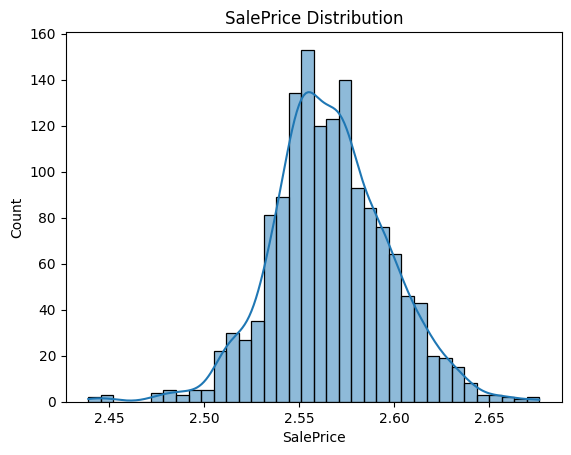

In [ ]:
#Exploratory Data Analysis
#Target Distribution
sns.histplot(train_df['SalePrice'], kde=True)
plt.title('SalePrice Distribution')
plt.show()


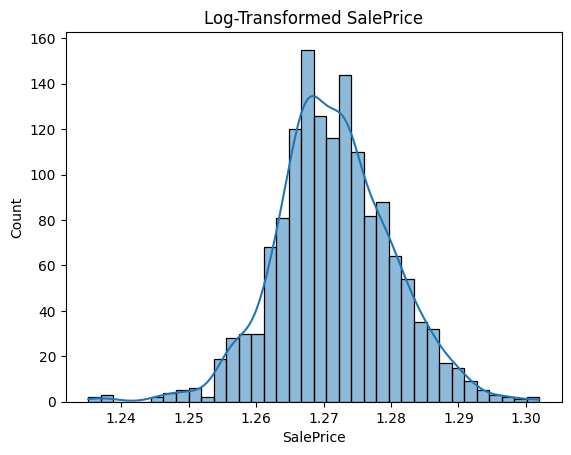

In [ ]:
#Log Transformation
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

sns.histplot(train_df['SalePrice'], kde=True)
plt.title('Log-Transformed SalePrice')
plt.show()


In [ ]:
num_df = train_df.select_dtypes(include=['int64', 'float64'])

# Drop Id column
num_df = num_df.drop(columns=['Id'])

corr_matrix = num_df.corr()


In [ ]:
#corelation Heatmap(Numerical Features)
num_df = train_df.select_dtypes(include=['int64', 'float64'])
corr_matrix = num_df.corr()


In [ ]:
num_df = train_df.select_dtypes(include=['int64', 'float64']).drop(columns=['Id'])
corr_matrix = num_df.corr()



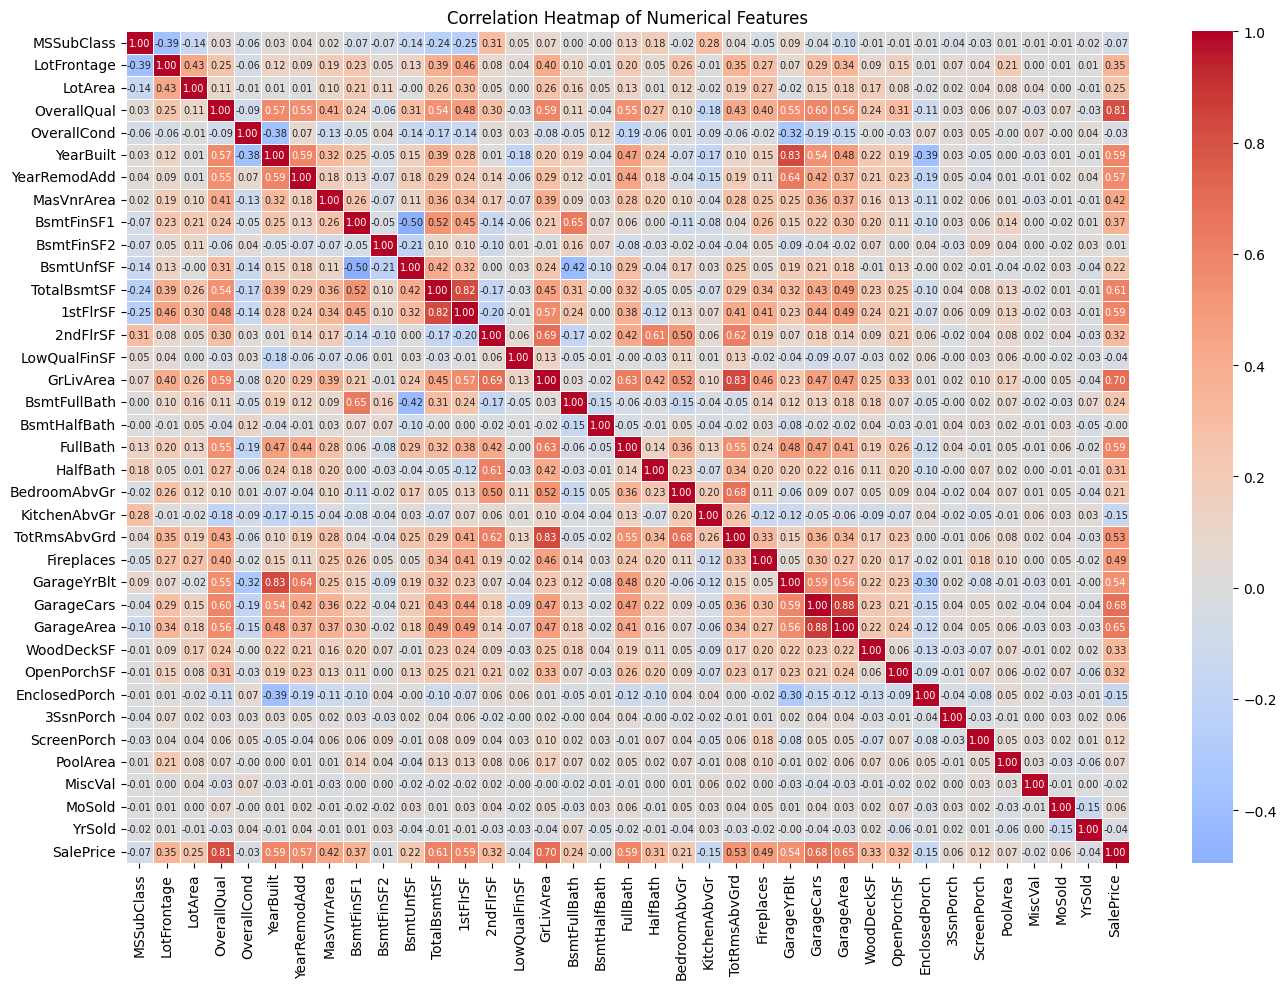

In [ ]:
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    center=0,
    linewidths=0.5,
    annot=True,          # 👈 add annotations
    fmt=".2f",           # 👈 2 decimal places
    annot_kws={"size": 7}  # 👈 keeps text readable
)
plt.title('Correlation Heatmap of Numerical Features')
plt.tight_layout()
plt.show()


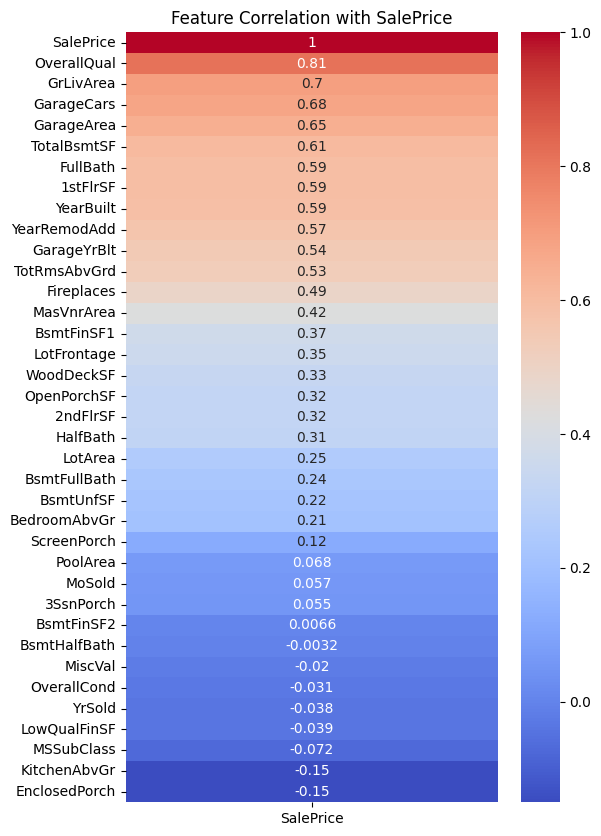

In [ ]:
top_corr = corr_matrix['SalePrice'].sort_values(ascending=False)

plt.figure(figsize=(6, 10))
sns.heatmap(top_corr.to_frame(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation with SalePrice')
plt.show()



In [ ]:
def remove_outliers_until_clean(df):
    changed = True
    while changed:
        before = len(df)
        df = (
            df
            .groupby('Neighborhood', group_keys=False)
            .apply(lambda g: g[
                (g['SalePrice'] >= g['SalePrice'].quantile(0.25) -
                 1.5 * (g['SalePrice'].quantile(0.75) - g['SalePrice'].quantile(0.25))) &
                (g['SalePrice'] <= g['SalePrice'].quantile(0.75) +
                 1.5 * (g['SalePrice'].quantile(0.75) - g['SalePrice'].quantile(0.25)))
            ]))
        after = len(df)
        changed = before != after
    return df


In [ ]:
train_df_strict = remove_outliers_until_clean(train_df)


C:\Users\AMISH\AppData\Local\Temp\ipykernel_15672\2675117661.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[
C:\Users\AMISH\AppData\Local\Temp\ipykernel_15672\2675117661.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g[
C:\Users\AMISH\AppData\Local\Temp\ipykernel_15672\2675117661.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior i

In [ ]:
train_df_strict.groupby('Neighborhood')['SalePrice'].apply(
    lambda s: ((s < s.quantile(0.25) - 1.5*(s.quantile(0.75)-s.quantile(0.25))) |
               (s > s.quantile(0.75) + 1.5*(s.quantile(0.75)-s.quantile(0.25)))).any()
)


Neighborhood
Blmngtn    False
Blueste    False
BrDale     False
BrkSide    False
ClearCr    False
CollgCr    False
Crawfor    False
Edwards    False
Gilbert    False
IDOTRR     False
MeadowV    False
Mitchel    False
NAmes      False
NPkVill    False
NWAmes     False
NoRidge    False
NridgHt    False
OldTown    False
SWISU      False
Sawyer     False
SawyerW    False
Somerst    False
StoneBr    False
Timber     False
Veenker    False
Name: SalePrice, dtype: bool

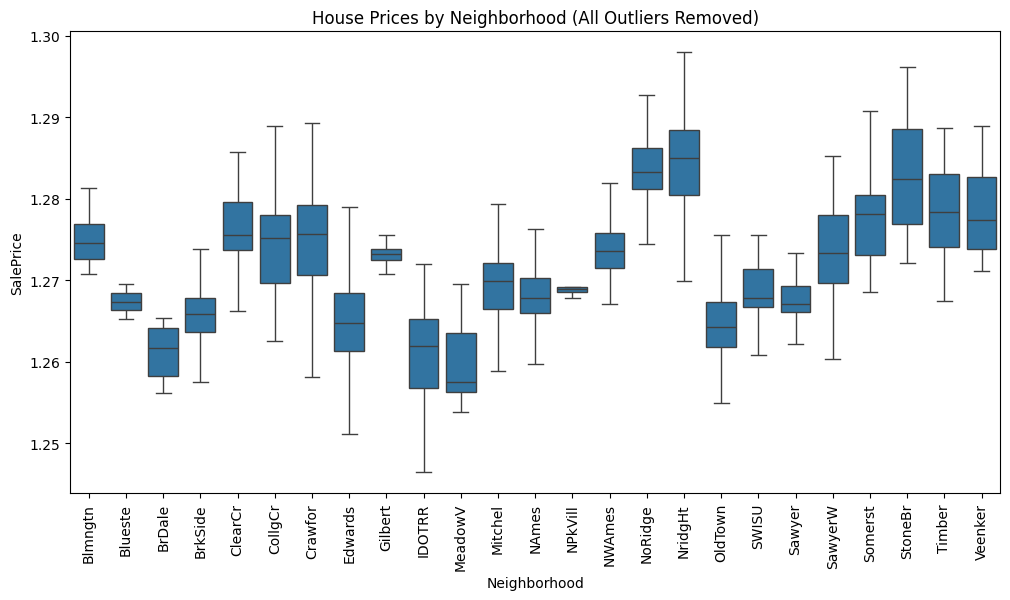

In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(
    x='Neighborhood',
    y='SalePrice',
    data=train_df_strict,
    showfliers=False
)
plt.xticks(rotation=90)
plt.title('House Prices by Neighborhood (All Outliers Removed)')
plt.show()


In [ ]:
# Target split
X = train_df.drop(['SalePrice', 'Id'], axis=1)
y = train_df['SalePrice']


In [ ]:
# Train/Vallidation split
X_train, X_valid, y_train, y_valid = train_test_split(
    X, y, test_size=0.2, random_state=42
)


In [ ]:
num_features = X_train.select_dtypes(include=['int64','float64']).columns
cat_features = X_train.select_dtypes(include=['object']).columns


In [ ]:
numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])

categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features),
    ('cat', categorical_transformer, cat_features)
])


In [ ]:
pipeline_rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=500, random_state=42, n_jobs=-1))
])

pipeline_gbr = Pipeline([
    ('preprocessor', preprocessor),
    ('model', GradientBoostingRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=3,
        random_state=42
    ))
])

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

pipeline_lgbm = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LGBMRegressor(
        n_estimators=500,
        learning_rate=0.05,
        num_leaves=31,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])


In [ ]:
models = {
    "RandomForest": pipeline_rf,
    "GradientBoosting": pipeline_gbr,
    "XGBoost": pipeline_xgb,
    "LightGBM": pipeline_lgbm
}

for name, model in models.items():
    cv_rmse = -cross_val_score(
        model,
        X,
        y,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1
    ).mean()
    print(f"{name} CV RMSE: {cv_rmse:.4f}")


RandomForest CV RMSE: 29746.2022
GradientBoosting CV RMSE: 25802.3896
XGBoost CV RMSE: 26826.9566
LightGBM CV RMSE: 28362.4167


In [ ]:
# Final fit
pipeline_xgb.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'Bs...
                              feature_types=None, feature_weights=None,
                              gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.05,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=6, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=500, n_jobs=None,
                              num_parallel_tree=None, ...))])

In [ ]:
# Validation metrics
preds = pipeline_xgb.predict(X_valid)

rmse = np.sqrt(mean_squared_error(y_valid, preds))
r2 = r2_score(y_valid, preds)

print("Validation RMSE:", rmse)
print("R²:", r2)


Validation RMSE: 24698.47347509558
R²: 0.9204708337783813


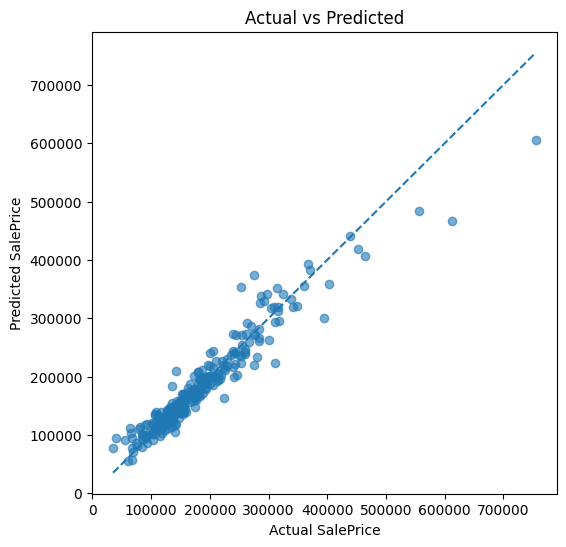

In [ ]:
plt.figure(figsize=(6,6))
plt.scatter(y_valid, preds, alpha=0.6)
plt.plot([y_valid.min(), y_valid.max()],
         [y_valid.min(), y_valid.max()],
         linestyle='--')
plt.xlabel("Actual SalePrice")
plt.ylabel("Predicted SalePrice")
plt.title("Actual vs Predicted")
plt.show()


In [ ]:
importances = pipeline_xgb.named_steps['model'].feature_importances_


In [ ]:
feature_names = pipeline_xgb.named_steps['preprocessor']\
    .get_feature_names_out()

imp_df = (
    pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    })
    .sort_values('importance', ascending=False)
    .head(20)
)

imp_df


,feature,importance
25,num__GarageCars,0.150025
3,num__OverallQual,0.140778
125,cat__RoofMatl_CompShg,0.088672
180,cat__BsmtQual_Ex,0.062429
221,cat__KitchenQual_Ex,0.043557
18,num__FullBath,0.043446
245,cat__GarageFinish_Unf,0.030649
49,cat__LandContour_Bnk,0.026713
15,num__GrLivArea,0.025939
168,cat__ExterQual_TA,0.025024


In [ ]:
bins = pd.qcut(y_valid, q=5)
error_by_bin = abs(residuals).groupby(bins).mean()
error_by_bin


C:\Users\AMISH\AppData\Local\Temp\ipykernel_15672\3270054013.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  error_by_bin = abs(residuals).groupby(bins).mean()


SalePrice
(35310.999, 119000.0]    13693.394466
(119000.0, 141000.0]      7958.365706
(141000.0, 175000.0]      9869.117996
(175000.0, 234800.0]     12518.201206
(234800.0, 755000.0]     31479.033104
Name: SalePrice, dtype: float64

In [ ]:
test_preds = pipeline_xgb.predict(test_df.drop('Id', axis=1))
test_preds = np.expm1(test_preds)  # invert log


C:\Users\AMISH\AppData\Local\Temp\ipykernel_15672\506997972.py:2: RuntimeWarning: overflow encountered in expm1
  test_preds = np.expm1(test_preds)  # invert log


In [ ]:
final_pipeline = pipeline_gbr


In [ ]:
residuals = y_valid - preds


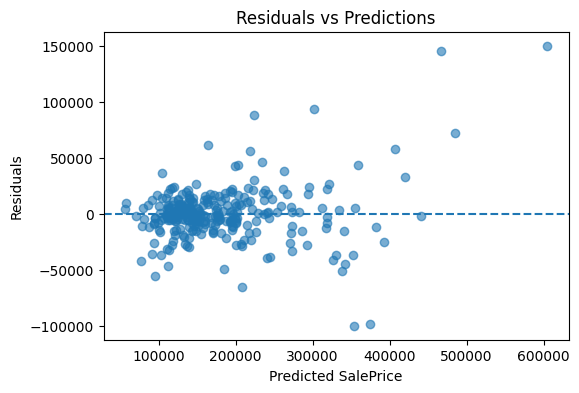

In [ ]:
plt.figure(figsize=(6,4))
plt.scatter(preds, residuals, alpha=0.6)
plt.axhline(0, linestyle='--')
plt.xlabel("Predicted SalePrice")
plt.ylabel("Residuals")
plt.title("Residuals vs Predictions")
plt.show()


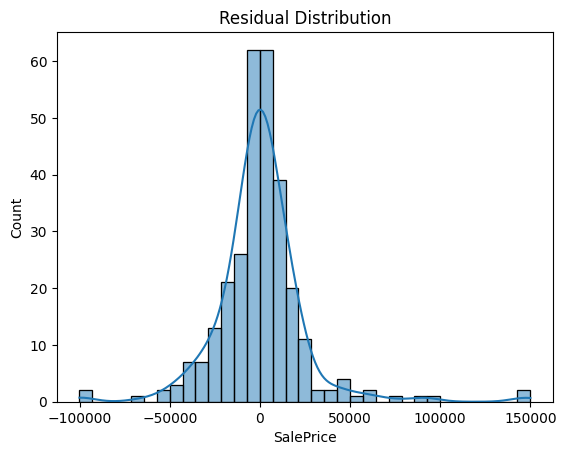

In [ ]:
sns.histplot(residuals, kde=True)
plt.title("Residual Distribution")
plt.show()


In [ ]:
final_pipeline.fit(X, y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median'))]),
                                                  Index(['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond',
       'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2',
       'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'Bs...
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object'))])),
                ('model',
                 GradientBoostingRegressor(learning_rate=0.05, n_estimators=300,
                                           random_state=42))])

In [ ]:
y.describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [ ]:
test_preds = final_pipeline.predict(test_df.drop('Id', axis=1))


In [ ]:
submission = pd.DataFrame({
    "Id": test_df["Id"],
    "SalePrice": test_preds
})

submission.to_csv("submission.csv", index=False)


In [ ]:
# Are prediction reasonable
test_preds[:10]


array([119720.40401889, 166069.00491585, 179547.65463767, 185888.86412305,
       188987.35184013, 175050.10758095, 165159.64001116, 163615.0293478 ,
       193965.9050735 , 125696.78133862])